# Mesh Generation using Gmsh
Gmsh is an open source 3D finite element mesh generator with a built-in CAD engine and post-processor. Its design goal is to provide a fast, light and user-friendly meshing tool with parametric input and advanced visualization capabilities.

## Installation
Several packages providing an interface to gmsh are available in the package manager (e.g., ``Gmsh.jl``, ``GmshTools.jl``, ``GmshBuilder.jl``), with varying levels of functionality and supported environments. The approach (or rather, workaround) used in the 2021/2022 edition of the EE4375 course is presented below. This uses the offical Julia interface provided in the gmsh SDK.

### Problem
Installing Gmsh.jl via the Pkg manager yields an error on Windows machines.
```
julia> using Pkg; Pkg.add("Gmsh")
ERROR: Error building `Gmsh`:
ERROR: LoadError: Your platform ("x86_64-w64-mingw32", parsed as "x86_64-w64-mingw32-gcc8-cxx11") is not supported by this package!
```

### Workaround
1. Download the Gmsh SDK from https://gmsh.info/ and unzip the contents.
2. Now, Gmsh can be used in Julia by executing
```
include("PATH_TO_SDK/lib/gmsh.jl")
```
where `PATH_TO_SDK` is the location where you unzipped the SDK files.
3. This is not ideal as permanent solution. To improve this, we can add the SDK /lib folder to Julia\'s `LOAD_PATH` and load it using the normal package inclusion methods. To do this, execute
```
push!(LOAD_PATH, "PATH_TO_SDK/lib")
using gmsh
```
4. To make this change permanent, the line
```
push!(LOAD_PATH, "PATH_TO_SDK/lib")
```
can be placed in the startup script located at `C:\Users\$user\.julia\config\startup.jl`. If this script is not present you can create it. Take care that the extension is `.jl` and not `.jl.txt`, which Windows is likely to do for you.
5. After making this change and restarting the Julia command prompt, you should be able to use
```
using gmsh
```
or
```
import gmsh
```
to use Gmsh as a package. Try this by executing one of the tutorial scripts in `PATH_TO_SDK\share\doc\gmsh\tutorials\julia`. These tutorials are also available [here](https://gitlab.onelab.info/gmsh/gmsh/-/tree/master/tutorials/julia).

In [15]:
using gmsh

## Mesh Definition: Basic Operations
Defining a mesh in Gmsh consists of several basic operations.

### Initializing the Model

In [16]:
gmsh.initialize()                                # Initialize Gmsh
gmsh.option.setNumber("General.Terminal", 1)     # Enable printing information to terminal
gmsh.model.add("example")                        # Create a new model named "example"

### Geometry Definition
First, the _geometry_ is defined using several basic building blocks:
 - Dimension 0: Points
 - Dimension 1: Curves
 - Dimension 2: CurveLoops, PlaneSurfaces
 - Dimension 3: Volumes
 
We will only use two-dimensional geometries for our FEM implementation, so the third dimension will not be discussed here. 

To illustrate the procedure, a unit square geometry will be made.

#### Dimension 0: Points
The first thing to be defined are the points (or nodes) of the geometry. The general command is

```
gmsh.model.geo.addPoint(x, y, z, meshSize, tag)
```

Here, the (three-dimensional) coordinates of the point are ``(x,y,z)``, the mesh density at the node is given by ``meshSize``, and the label which will be used to refer to the point is ``tag``. If a one or two-dimensional geometry is desired, one or more of the coordinates can be fixed to 0.

In [17]:
mshd = 0.1; # Mesh density
gmsh.model.geo.addPoint(0, 0, 0, mshd, 1);
gmsh.model.geo.addPoint(1, 0, 0, mshd, 2);
gmsh.model.geo.addPoint(1, 1, 0, mshd, 3);
gmsh.model.geo.addPoint(0, 1, 0, mshd, 4);

#### Dimension 1: Curves
Next, line connections between points are defined. These come in a variety of flavours:
 - Line: Straight connection between two points.
 - CircleArc: Circle arc between two points, with the center defined by a third point.
 - Bezier: Bezier curve with any number of control points.

The corresponding functions to be executed in Julia are:
```
gmsh.model.geo.addLine(startTag, endTag, tag)
gmsh.model.geo.addCircleArc(startTag, centerTag, endTag, tag)
gmsh.model.geo.addBezier(pointTags, tag)
```

Other types of curves can be found in the [documentation](http://gmsh.info/doc/texinfo/gmsh.html#Curves).

It is important to note that curves are _directional_, i.e., they have an explicit start and end point. This property will be used later in the construction of surfaces.

In [18]:
gmsh.model.geo.addLine(1, 2, 1);
gmsh.model.geo.addLine(2, 3, 2);
gmsh.model.geo.addLine(3, 4, 3);
gmsh.model.geo.addLine(4, 1, 4);

#### Dimension 2: CurveLoops and PlaneSurfaces
Curve loops are closed (directional!) loops of curves, and form the _boundary_ of our surfaces. Any number of curves can be combined to form a loop, provided that their orientation is such that formation of a closed loop is possible. 
```
gmsh.model.geo.addCurveLoop(curveTags, tag)
gmsh.model.geo.addCurveLoop(curveTags, tag, reorient)
```
If one of the curves is oriented the wrong way, a situation that will arise often in complex geometries, its direction can be _reversed_ using a negative sign in the loop definition. If ``reorient`` is set to true, the curves are automatically reoriented if necessary.

Using the curve loop, a plane surface can be constructed (as noted before, the curve loop is the boundary of the surface). The corresponding function is
```
gmsh.model.geo.addPlaneSurface(curveLoopTags, tag)
```
The first curve loop defines the exterior contour. Any additional curve loops define holes in the plane surface.

In [19]:
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1);

gmsh.model.geo.addPlaneSurface([1], 1);

### Physics Definition

## Generating and Viewing Meshes

In [20]:
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000993967s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.017952s, CPU 0.015625s)
Info    : 142 nodes 286 elements


In [21]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.9.4
License       : GNU General Public License
Build OS      : Windows64-sdk
Build date    : 20220203
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen NoSocklenT ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.15.0 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : nt authority system
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


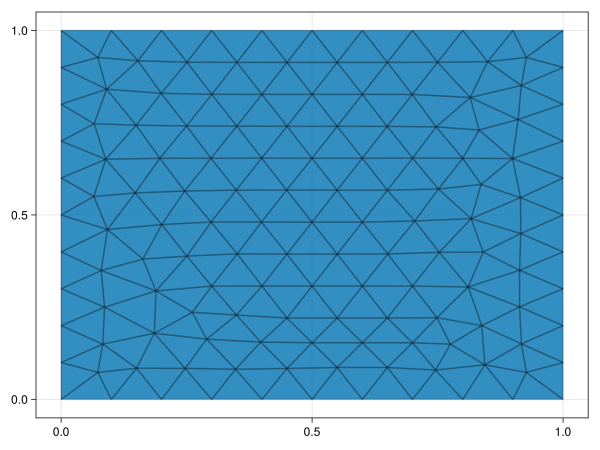

In [22]:
msh = get_mesh()

f, ax, pl = mesh(msh, shading = false)
wireframe!(ax, msh, color=(:black, 0.2), linewidth=2, transparency=true)
current_figure()

## Accessing Mesh Data in Julia

In [23]:
using CairoMakie
using GeometryBasics

CairoMakie.activate!(type = "svg")

In [24]:
# Obtain a GeometryBasics.Mesh object suitable for plotting with Makie
function get_mesh()
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nNode = length(node_ids)

    eType, eTag, eConn = gmsh.model.mesh.getElements(2);
    nEl = length(eTag[1])

    points   = zeros(Point2f, nNode);          # Array of vertex coordinates (x,y)
    trif     = zeros(TriangleFace{Int}, nEl);  # Array of triangular faces (n1, n2, n3)
    
    for n in 1:nNode
        points[node_ids[n]] = Point2f(node_coord[3*(n-1) + 1], node_coord[3*(n-1) + 2])
    end
    for e in 1:nEl
        trif[e] = (eConn[1][3*(e-1)+1], eConn[1][3*(e-1)+2], eConn[1][3*(e-1)+3])
    end
    
    msh = GeometryBasics.Mesh(points, trif);
    return msh;
end

get_mesh (generic function with 1 method)

## Examples

### Example 1: Square with Hole

In [25]:
gmsh.finalize()
gmsh.initialize()

In [26]:
mshd_out = 0.2; # Mesh density at outer boundary
mshd_in  = 0.05; # Mesh density at inner boundary

gmsh.model.add("square_hole")
geo = gmsh.model.geo;

## Points
geo.addPoint(0, 0, 0, mshd_out, 1);
geo.addPoint(1, 0, 0, mshd_out, 2);
geo.addPoint(1, 1, 0, mshd_out, 3);
geo.addPoint(0, 1, 0, mshd_out, 4);

geo.addPoint(0.3, 0.3, 0, mshd_in, 5);
geo.addPoint(0.7, 0.3, 0, mshd_in, 6);
geo.addPoint(0.7, 0.7, 0, mshd_in, 7);
geo.addPoint(0.3, 0.7, 0, mshd_in, 8);

## Curves
geo.addLine(1, 2, 1);
geo.addLine(2, 3, 2);
geo.addLine(3, 4, 3);
geo.addLine(4, 1, 4);

geo.addLine(5, 6, 5);
geo.addLine(6, 7, 6);
geo.addLine(7, 8, 7);
geo.addLine(8, 5, 8);

## Surfaces
geo.addCurveLoop([1, 2, 3, 4], 1)  # Outer boundary
geo.addCurveLoop([5, 6, 7, 8], 2)  # Inner boundary

geo.addPlaneSurface([1, 2], 1) # Square with hole

# Generate mesh
geo.synchronize();
gmsh.model.mesh.generate(2)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.000997782s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00299215s, CPU 0.015625s)
Info    : 116 nodes 240 elements


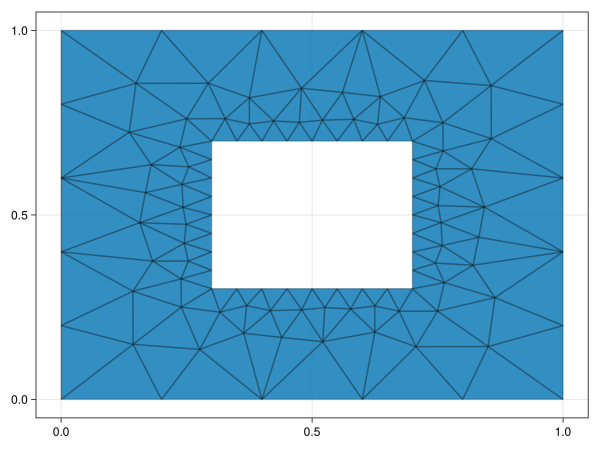

In [27]:
msh = get_mesh()

f, ax, pl = mesh(msh, shading = false)
wireframe!(ax, msh, color=(:black, 0.2), linewidth=2, transparency=true)
current_figure()

### Example 2: Coaxial Cable

## Exercises

## References & Further Reading
- Gmsh website (http://gmsh.info/)
- Gmsh reference manual (http://gmsh.info/doc/texinfo/gmsh.html)
- Selection of gmsh tutorials in Julia (https://gitlab.onelab.info/gmsh/gmsh/-/tree/master/tutorials/julia)